In [1]:
%run imports.py

In [2]:
def get_mask_area_ratio(mask):
    foreground = (mask == 1).sum().item() 
    total_pixels = mask.numel() 
    return foreground / total_pixels

def get_test_dataset(subsets_path, choosen_test_subsets = ["i", "j"]):
    test_subsets = []
    for subset in os.listdir(subsets_path):
        if subset.split(".")[0].split("_")[1] in choosen_test_subsets:
            with open(f'{subsets_path}/{subset}', "rb") as f:
                data = pickle.load(f)
            test_subsets.append(data)
    test_data = ConcatDataset(test_subsets)
    
    test_dataset = KvasirDataset(data=test_data, 
                                 mode="test", 
                                 image_size=ast.literal_eval(env_vars["image_size"]), 
                                 mask_size=ast.literal_eval(env_vars["mask_size"]))
    
    return test_dataset

def get_train_dataset(subsets_path, choosen_test_subsets = ["i", "j"]):
    test_subsets = []
    for subset in os.listdir(subsets_path):
        if subset.split(".")[0].split("_")[1] not in choosen_test_subsets:
            with open(f'{subsets_path}/{subset}', "rb") as f:
                data = pickle.load(f)
            test_subsets.append(data)
    train_data = ConcatDataset(test_subsets)
    
    train_dataset = KvasirDataset(data=train_data, 
                                 mode="test", 
                                 image_size=ast.literal_eval(env_vars["image_size"]), 
                                 mask_size=ast.literal_eval(env_vars["mask_size"]))
    
    return train_dataset

def get_mask_area_ratio(mask_data):
    if isinstance(mask_data, torch.Tensor):
        mask = mask_data
    elif isinstance(mask_data, np.ndarray):
        mask = torch.tensor(mask_data)
    elif isinstance(mask_data, Image.Image):
        mask = torch.tensor(np.array(mask_data))
    else:
        raise TypeError(f"Unsupported mask type: {type(mask_data)}")

    foreground = (mask == 1).sum().item()
    return foreground / mask.numel()

def get_binwise_data(dataset, n_bins):
    area_bins = np.linspace(0, 1, n_bins + 1)
    data_bins = [[] for _ in range(len(area_bins)-1)]
    for idx in range(len(dataset)):
        mask_data = dataset[idx][1]
        area_ratio = get_mask_area_ratio(mask_data=mask_data)
        for j in range(len(area_bins)-1):
            if area_ratio >= area_bins[j] and area_ratio < area_bins[j+1]:
                data_bins[j].append(dataset[idx][1])
    return data_bins

In [17]:
def get_mask_localization(data_bins, bin_idx, savefigname):
    h, w = data_bins[bin_idx][1].size()[-2], data_bins[bin_idx][1].size()[-1]
    
    matrix = np.zeros((h, w))
    
    for i in range(len(data_bins[bin_idx])):
        mask = data_bins[bin_idx][i]
        
        mask = mask.squeeze() 
        for hi in range(h):
            for wi in range(w):
                if mask[hi, wi] == 1:  
                    matrix[hi, wi] += 1  
        
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label="Frequency")
    plt.title(f"Mask Localization Heatmap for bin index : {bin_idx}")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.savefig(f"../outputs/figures/{savefigname}_bin{bin_idx}.pdf")
    plt.show()

    

In [4]:
train_dataset = get_train_dataset(subsets_path=f"../data/subsets")
test_dataset = get_test_dataset(subsets_path=f"../data/subsets")
full_dataset = ConcatDataset([train_dataset, test_dataset])
data_bins = get_binwise_data(dataset=full_dataset, n_bins=50)

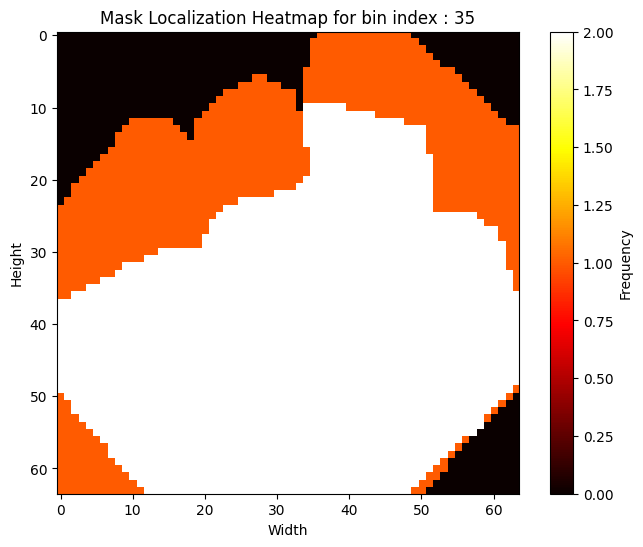

In [25]:
get_mask_localization(data_bins, 
                      bin_idx=35, 
                      savefigname="mask_localization")